# Surface Energy Budget in 6 hourly single column data
This looks at the hottest day of the year using 6 hourly data i.e. can we predict hottest day of year based on max input flux.

In [159]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [160]:
# Calculate Drag coefficient from LH and other parameters in dataset
# def get_drag_coef(flux_lhe, temp_surf, temp_diseqb, rh, p_surf, evap_prefactor, wind_speed, sigma):
#     # Could also compute from sensible heat as a sanity check
#     temp_a = temp_surf - temp_diseqb
#     p_a = p_surf*sigma
#     rho = get_density(temp_a, p_a)
#     sphum_a = rh * sphum_sat(temp_a, p_a)
#     return flux_lhe / (evap_prefactor * L_v * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a))

def get_drag_coef(flux_t, temp_surf, temp_diseqb, wind_speed, sigma, p_surf=None, density=None):
    # From sensible heat as no evap fraction which can be 0.
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf*sigma
        density = get_density(temp_a, p_a)
    return flux_t / (c_p * density * wind_speed * (temp_surf - temp_a * (1/sigma)**kappa))

def get_temp_rad(lwdn_sfc, lat):
    # Returns radiative temperature, T_r, such that LW_down = sigma T_r^4 (1 - e^{-opd})
    opd = opd_lw_gray(lat)
    emission_factor = 1 - np.exp(-opd)
    return (lwdn_sfc / emission_factor / Stefan_Boltzmann)**0.25

In [169]:
# Load dataset - one at surface and one in free troposphere
# var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc',
#             'flux_lhe', 'flux_t', 'ps', 'precipitation']
var_keep = ['temp', 'sphum', 'height', 't_surf', 'ps', 'precipitation', 'soc_toa_sw_down', 'soc_surf_flux_sw_down', 'soc_surf_flux_sw',
            'soc_surf_flux_lw_down', 'soc_surf_flux_lw', 'flux_lhe', 'flux_t']
# Load dataset

# # DEFAULT experiment
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/column/'
# exp_name = ['evap=0']
exp_name = ['socrates']


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
if 'column_nml' in namelist:
    p_surface_approx = namelist['column_nml']['reference_sea_level_press']/100
else:
    p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

if 'column_nml' in namelist:
    # In single column, wind is constant and has default value of 5m/s
    try:
        w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['column_init_cond_nml']['surface_wind']
    except KeyError:
        w_atm_const = 5
else:
    w_atm_const = None
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1
try:
    land_h_capacity_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['mixed_layer_nml']['land_h_capacity_prefactor']
except KeyError:
    land_h_capacity_prefactor = 1

n_exp = len(exp_name)
lat_range = slice(0, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
pressure_ft = 500
# use_time_start = cftime.Datetime360Day(10, 1, 1)   # Year 10, January 1st
use_time_start = cftime.Datetime360Day(1, 1, 1)   # Year 10, January 1st
use_time_end = cftime.Datetime360Day(9000, 12, 30)  # Year 9000, December 30th (basically infinity)
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i], decode_times=True)
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, use_time_end)).sel(lat=lat_range)
    ds_use = ds_use.sel(pfull=[np.inf, 500], method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    # ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp.isel(pfull=0)**4)
    # # ds_use['temp_diseqb_lw'] = ds_use.t_surf - (ds_use.lwdn_sfc/Stefan_Boltzmann)**0.25
    # ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp.isel(pfull=0)
    # ds_use['rh'] = ds_use.sphum.isel(pfull=0) / sphum_sat(ds_use.temp.isel(pfull=0), ds_use.ps*sigma_near_surf)
    # ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    # ds_use['flux_sfc_dn_net'] = ds_use.swdn_sfc + ds_use.lwdn_sfc - ds_use.lwup_sfc - ds_use.flux_lhe - ds_use.flux_t
    # # Compute deviation from lowest level and radiative temperature given surface optical depth
    # ds_use['temp_diseqb_rad'] = ds_use.temp.isel(pfull=0) - get_temp_rad(ds_use.lwdn_sfc, ds_use.lat)
    # if 'drag_q' not in ds_use:
    #     # Need to change this if evap_prefactor changes with latitude
    #     ds_use['drag_q'] = get_drag_coef(ds_use.flux_t, ds_use.t_surf, ds_use.temp_diseqb, w_atm_const, sigma_near_surf, ds_use.ps)
    # if 'w_atm' not in ds_use:
    #     ds_use['w_atm'] = ds_use['drag_q']*0+w_atm_const        # keep dimensions is useful for functions later
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = {'ocean': namelist['mixed_layer_nml']['depth']}
mixed_layer_depth['land'] = namelist['mixed_layer_nml']['land_h_capacity_prefactor'] * mixed_layer_depth['ocean']
ind_surf = 0
ind_ft = 1
pressure_ft_actual = float(ds_base[0].pfull[ind_ft]*100)
p_surface = float(ds_base[0].pfull[ind_surf]*100)

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 2 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


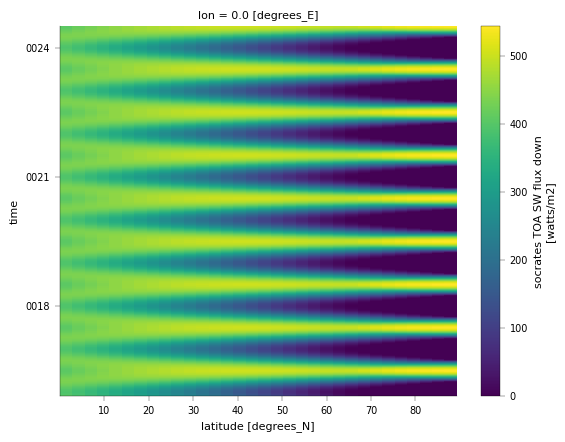

In [162]:
ds_base[0].soc_toa_sw_down.isel(lon=0).plot()

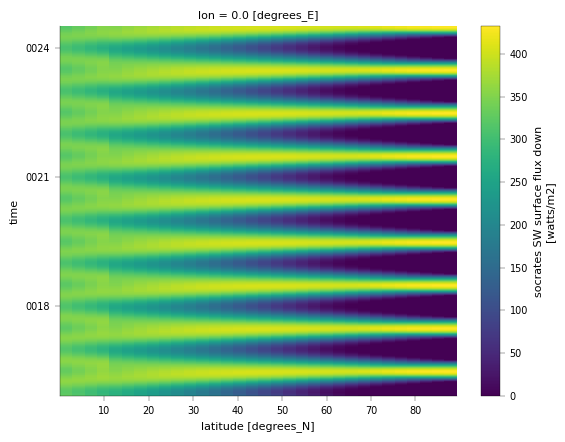

In [163]:
ds_base[0].soc_surf_flux_sw_down.isel(lon=0).plot()

300.3027


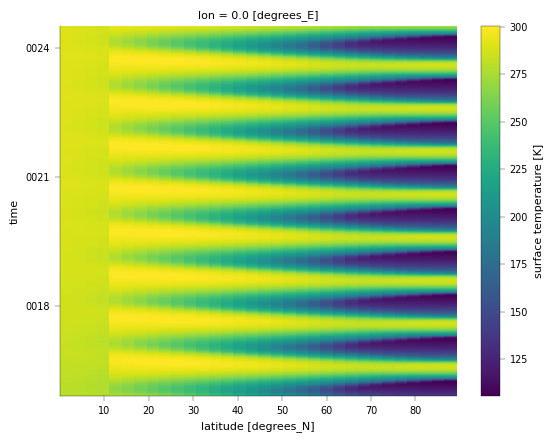

In [164]:
ds_base[0].t_surf.isel(lon=0).plot()
print(ds_base[0].t_surf.max().values)

In [170]:
namelist['mixed_layer_nml']['albedo_value']

0.36

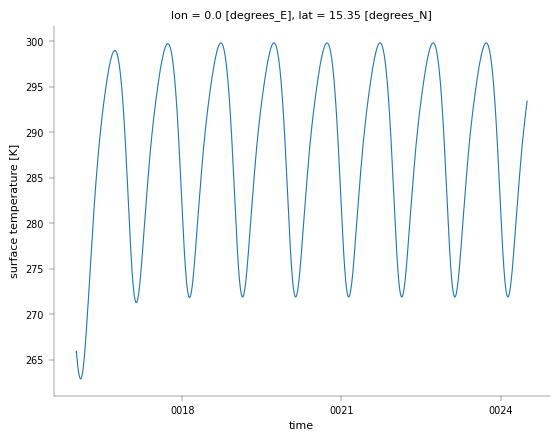

In [177]:
# ds_base[0].t_surf.isel(lat=0, lon=0).plot()
# ds_base[0].t_surf.isel(lat=3, lon=0).plot()
ds_base[0].t_surf.isel(lat=5, lon=0).plot()
# ds_base[0].t_surf.isel(lat=8, lon=0).plot()
# ds_base[0].t_surf.isel(lat=14, lon=0).plot()
# ds_base[0].t_surf.isel(lat=-1, lon=0).plot()

In [128]:
ds_base[0].t_surf.isel(time=slice(300, -1)).isel(lon=0, lat=0).max()
# ds_base[0].t_surf.isel(lon=0, lat=5).plot()

<xarray.DataArray 't_surf' ()> Size: 4B
array(274.80267, dtype=float32)
Coordinates:
    lon      float64 8B 0.0
    lat      float64 8B 1.395

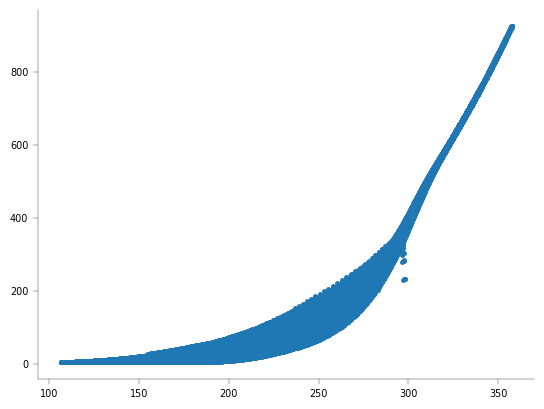

In [105]:
plt.scatter(ds_base[0].t_surf, ds_base[0].soc_surf_flux_lw_down)

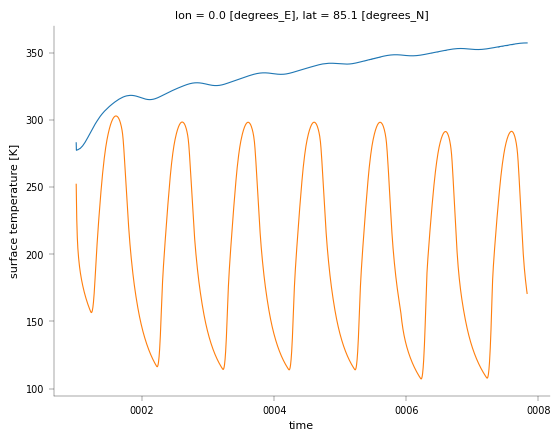

In [87]:
ds_base[0].t_surf.isel(lon=0, lat=4).plot()
ds_base[0].t_surf.isel(lon=0, lat=-2).plot()

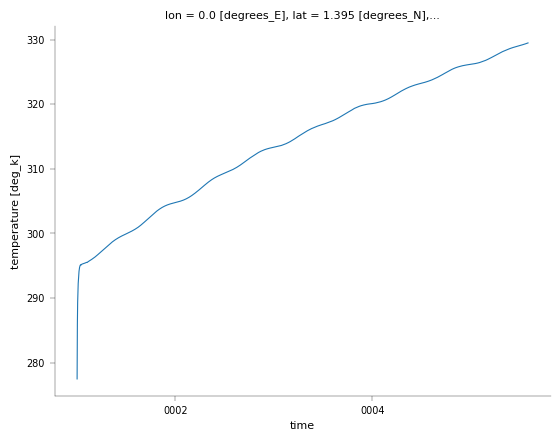

In [32]:
# ds_base[0].t_surf.isel(lon=0, lat=4).plot()
ds_base[0].temp.isel(lon=0, lat=0, pfull=0).plot()
# ds_base[0].sphum.isel(lon=0, lat=4, pfull=0).plot()

In [54]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_lat = [np.floor(ds_base[0].lat[0]), np.ceil(ds_base[0].lat[-1])]
ax_lims_time = [0, 360]

In [55]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_name[0].replace('_6_hours', ''), 'land.nc')
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]  # get the latitude coordinates of land
lat_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[0]
lat_land_min = (lat_land.min() + lat_ocean.max()) / 2           # show land in plots as average between ocean and land extrema

# Add heat capacity to dataset
ds_base[0]['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth['land'] *
                                                (ds_base[0].lat > lat_land_min) + mixed_layer_depth['ocean'] * (ds_base[0].lat < lat_land_min))

## Get Day and Night Datasets
Here, I select the dataset for night (9PM - 3AM) and day (9AM - 3PM) on each day; and average over all years to get a dataset with one value for each day of the year. I then smooth this over 20 days.

In [56]:
def get_smooth_array(ds, window=20, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_day_night_diff(ds, hour_day=12, hour_night=6):
    # Return dataset which is that of daytime minus that of night immediately preceeding it
    # The time in the returned array will be that of daytime i.e. the hour will be set to hour_day for all time values
    for hour in [hour_day, hour_night]:
        if hour not in ds.time.dt.hour:
            raise ValueError(f'hour must be in {np.unique(ds.time.dt.hour)} but {hour} given')
    ds_day = ds.where(ds.time.dt.hour == hour_day, drop=True)
    ds_day.assign_coords(time=ds_day.time)
    ds_night = ds.where(ds.time.dt.hour == hour_night, drop=True)
    ds_night = ds_night.assign_coords(time=ds_day.time)
    return ds_day - ds_night

def get_annual_mean_at_hour(ds, hour=12):
    # Returns dataset wth only a given hour at each day, and then for each day average over all years of dataset.
    # Returned dataset only has 360 time values (one for each year)
    if hour not in ds.time.dt.hour:
        raise ValueError(f'hour must be in {np.unique(ds.time.dt.hour)} but {hour} given')
    ds_use = ds.where(ds.time.dt.hour == hour, drop=True)
    return ds_use.groupby("time.dayofyear").mean(dim="time")


smooth_sz = 20   # smooth over 20 days
if 'hour' in exp_name[0]:
    hour_day = 12
    hour_night = 0
    hour_morning = 6
else:
    # If not hourly data, saved as midday - plots will all be the same
    hour_day = 12
    hour_night = 12
    hour_morning = 12
ds = {'night': get_smooth_array(get_annual_mean_at_hour(ds_base[0].isel(lon=0, drop=True), hour=hour_night), smooth_sz).load(),
      'day': get_smooth_array(get_annual_mean_at_hour(ds_base[0].isel(lon=0, drop=True), hour=hour_day), smooth_sz).load(),
      'diff': get_smooth_array(get_annual_mean_at_hour(get_day_night_diff(ds_base[0].isel(lon=0, drop=True), hour_day, hour_night),
                                                       hour=hour_day), smooth_sz).load(),
      'morning': get_smooth_array(get_annual_mean_at_hour(ds_base[0].isel(lon=0, drop=True), hour=hour_morning), smooth_sz).load()}

## Quick Overview Plots
### Daytime vs Night-time Plots
Below, I plot the day and night distributions of downward shortwave radiation, relative humidity and $T_{diseqb}$ (which is the surface minus lowest level of atmosphere temperature).

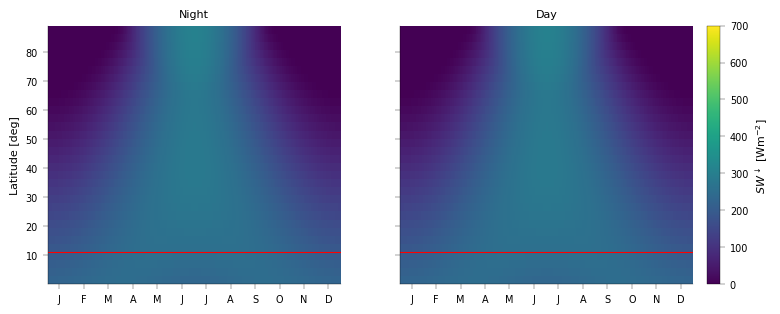

In [57]:
show_overview_figs = True
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].swdn_sfc.transpose(), vmin=0, vmax=700)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$SW^{\\downarrow}$ [Wm$^{-2}$]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

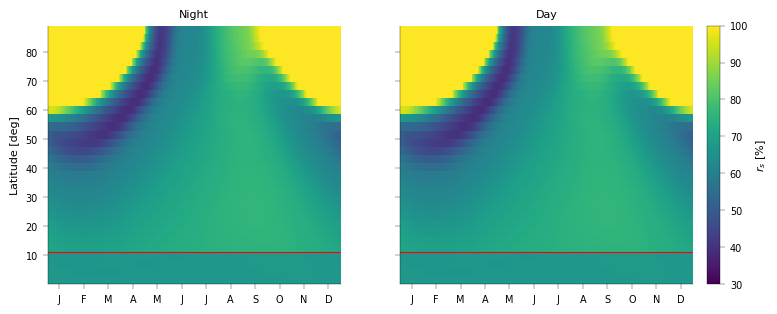

In [58]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].rh.transpose()*100, vmin=30, vmax=100)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$r_s$ [%]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

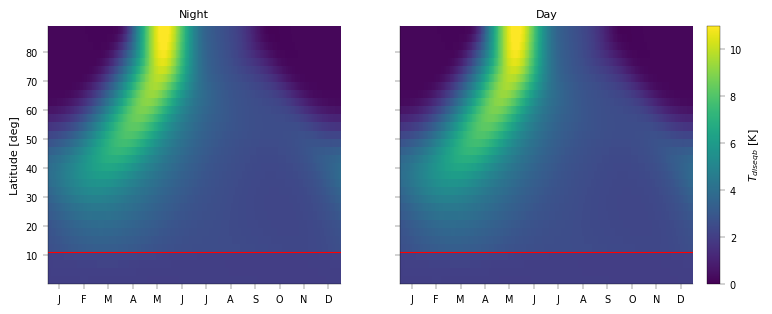

In [59]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].temp_diseqb.transpose(), vmin=0, vmax=11)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

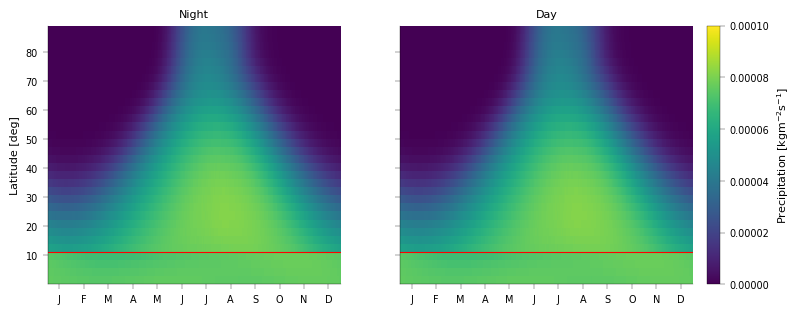

In [60]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].precipitation.transpose(), vmin=0, vmax=10e-5)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

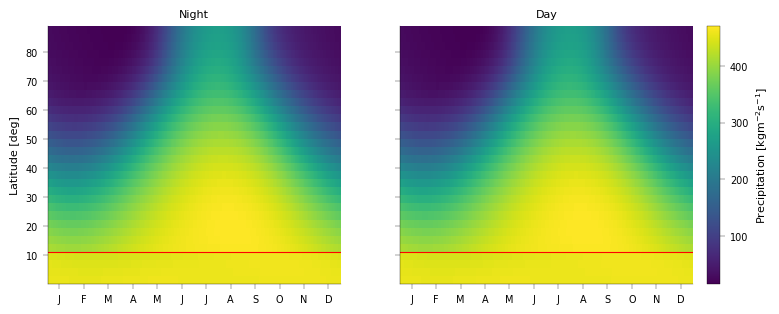

In [61]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].lwdn_sfc.transpose())
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

### Diurnal Cycle
Below, I plot the diurnal cycle of temperature at various levels; followed by the latent and sensible heat plots.

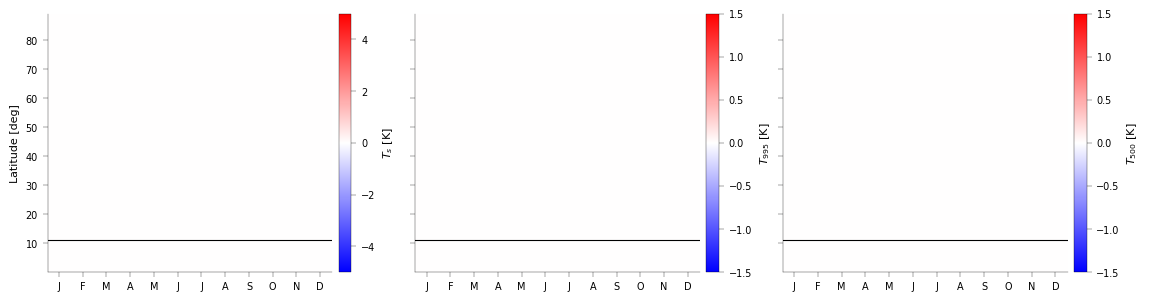

In [62]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
im = ax[0].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds['diff'].t_surf.transpose(), cmap='bwr', vmin=-5, vmax=5)
plt.colorbar(im, ax=ax[0], fraction=0.05, pad=0.02, label='$T_s$ [K]')
im = ax[1].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds['diff'].temp[:, ind_surf].transpose(), cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(im, ax=ax[1], fraction=0.05, pad=0.02, label=f'$T_{"{"+str(int(round(p_surface/100, 0)))+"}"}$ [K]')
im = ax[2].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds['diff'].temp[:, ind_ft].transpose(), cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(im, ax=ax[2], fraction=0.05, pad=0.02, label=f'$T_{"{"+str(pressure_ft)+"}"}$ [K]')
for i in range(3):
    ax[i].axhline(lat_land_min, color='k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

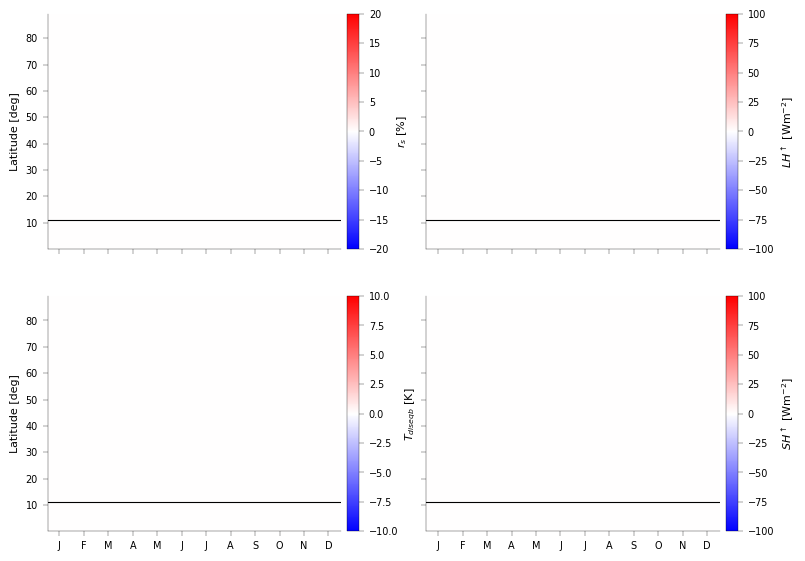

In [63]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
im = ax[0, 0].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].rh.transpose()*100, cmap='bwr', vmin=-20, vmax=20)
plt.colorbar(im, ax=ax[0, 0], fraction=0.05, pad=0.02, label='$r_s$ [%]')
im = ax[0, 1].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].flux_lhe.transpose(), cmap='bwr', vmin=-100, vmax=100)
plt.colorbar(im, ax=ax[0, 1], fraction=0.05, pad=0.02, label='$LH^{\\uparrow}$ [Wm$^{-2}$]')
im = ax[1, 0].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].temp_diseqb.transpose(), cmap='bwr', vmin=-10, vmax=10)
plt.colorbar(im, ax=ax[1, 0], fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
im = ax[1, 1].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].flux_t.transpose(), cmap='bwr', vmin=-100, vmax=100)
plt.colorbar(im, ax=ax[1, 1], fraction=0.05, pad=0.02, label='$SH^{\\uparrow}$ [Wm$^{-2}$]')
for ax_use in ax.flatten():
    ax_use.axhline(lat_land_min, color='k')
ax[0,0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

In [64]:
def get_extrema_coordinates(da, max=True):
    """
    Find the coordinates of the maximum value in a 2D xarray DataArray.

    Parameters:
    da (xarray.DataArray): A 2D DataArray with unknown coordinate names.

    Returns:
    dict: A dictionary with the coordinate names, their values, and the max value.
    """
    if da.ndim != 2:
        raise ValueError("Input DataArray must be 2D.")

    # Get dimension names dynamically
    dim1, dim2 = da.dims  # First and second dimension names

    # Find max index
    if max:
        max_index = da.argmax().item()  # Get flattened index of max
    else:
        max_index = da.argmin().item()
    max_coords = np.unravel_index(max_index, da.shape)  # Convert to 2D indices

    # Extract the coordinate values dynamically
    coord1_max = da[dim1].values[max_coords[0]]
    coord2_max = da[dim2].values[max_coords[1]]
    max_value = da.values[max_coords]

    return {dim1: coord1_max, dim2: coord2_max, "extrema_value": max_value}

## Hottest Day of the Year
Below, we plot the location of the hottest day of the year with white markers. It is clear, that it is the same regardless of the time of they that you want to compute it (although hottest morning day is actually in the ocean).

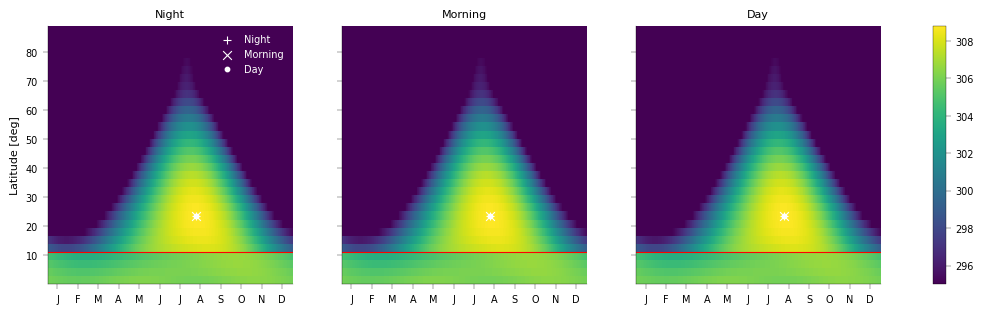

In [65]:
coords_max_temp = {key: get_extrema_coordinates(ds[key].t_surf.where(ds[key].lat>lat_land_min, drop=True)) for key in ds}
marker_use = {'night': '+', 'morning':'x', 'day': '.'}
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['night', 'morning', 'day']):
    im=ax[i].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds[key].t_surf.transpose(), vmin=295, vmax=ds['day'].t_surf.max())
    for key2 in ['night', 'morning', 'day']:
        ax[i].scatter(coords_max_temp[key2]['dayofyear'], coords_max_temp[key2]['lat'], color='w', marker=marker_use[key2], s=40, label=key2.capitalize())
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
plt.colorbar(im, ax=ax.ravel())
ax[0].legend(labelcolor='w')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Net input radiation
We were wondering if the hottest day is simply the day which has the most net radiation into the surface. Clearly, this is not the case as shown below, whereby the day with max day-time temperature tendency at the location of the hottest day is in March.

This is not really surprising, as from above the morning of the hottest day is also the hottest morning; so it does not need the largest tendency as well. I.e. if all days had the same morning temperature, then the day with most net radiation into surface would be the hottest day.

Also, the hotter the day, the larger the upward longwave and latent heat fluxes, so it is not surprising that the hot day has fairly average to low temperature tendency.

So something varying on the time scale of days is setting the underlying seasonal daily average temperature cycle; and the diurnal cycle acts on top of this.

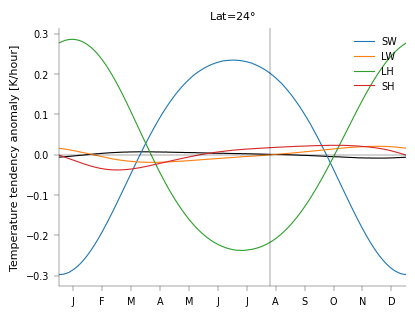

In [66]:
def get_anom(ds, dim='dayofyear'):
    return ds - ds.mean(dim=dim)

n_seconds_hour = 60**2
ds_use = ds['day'].sel(lat=coords_max_temp['day']['lat'])

fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
ax.plot(ds_use.dayofyear, get_anom(ds_use.flux_sfc_dn_net)/ds_use.heat_capacity*n_seconds_hour, color='k')
ax.plot(ds_use.dayofyear, get_anom(ds_use.swdn_sfc)/ds_use.heat_capacity*n_seconds_hour, label='SW')
ax.plot(ds_use.dayofyear, get_anom(ds_use.lwdn_sfc-ds_use.lwup_sfc)/ds_use.heat_capacity*n_seconds_hour, label='LW')
ax.plot(ds_use.dayofyear, -get_anom(ds_use.flux_lhe)/ds_use.heat_capacity*n_seconds_hour, label='LH')
ax.plot(ds_use.dayofyear, -get_anom(ds_use.flux_t)/ds_use.heat_capacity*n_seconds_hour, label='SH')
ax.axvline(coords_max_temp['day']['dayofyear'], color='k', lw=ax_linewidth)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend()
ax.set_xticks(*month_ticks)
ax.set_xlim(0, 360)
ax.set_ylabel('Temperature tendency anomaly [K/hour]')
ax.set_title('Lat={:.0f}$\degree$'.format(ds_use.lat))
plt.show()
# get_anom(ds_use.swdn_sfc).plot(label='SWDN')
# ds_use.flux_lhe.plot()
# ds_use.flux_t.plot()
# ds_use.lwdn_sfc.plot()
# ds_use.lwup_sfc.plot()

### Optical Depth Variation with latitude
Below I compare the variation with latitude of the emission factor versus the imposes surface longwave optical depth. The emission factor is smaller because the radiative emission temperature is lower than that of the near-surface.

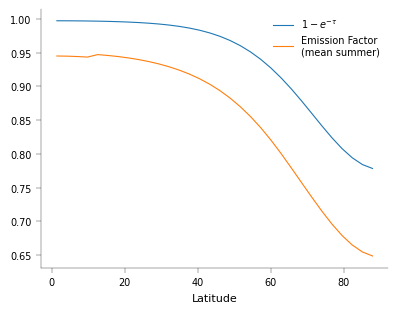

In [89]:
time_summer = slice(150, 230)
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
ax.plot(ds['day'].lat, 1 - np.exp(-opd_lw_gray(ds['day'].lat)), label='$1-e^{-\\tau}$')
ax.plot(ds['day'].lat, ds['day']['emission_factor'].sel(dayofyear=time_summer).mean(dim='dayofyear'), label='Emission Factor\n(mean summer)')
ax.legend()
ax.set_xlabel('Latitude')
plt.show()

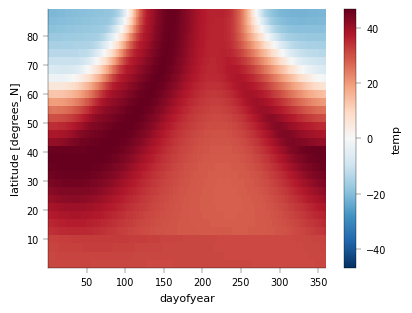

In [91]:
# Plot lapse rate to show unphysical at poles
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
(ds['day']['temp'].isel(pfull=0) - ds['day']['temp'].isel(pfull=1)).transpose().plot(ax=ax)
plt.show()

In [111]:
def get_land_median_var(ds, var):
    return float(ds[var].sel(lat=slice(lat_land_min, np.inf)).median())
const_params = {var: get_land_median_var(ds['day'], var) for var in ['ps', 'drag_q', 'rh', 'temp_diseqb', 'temp_diseqb_rad']}
const_params['w_atm'] = w_atm_const
const_params

{'ps': 100000.0,
 'drag_q': 0.0011636314447969198,
 'rh': 0.7144337296485901,
 'temp_diseqb': 2.774156093597412,
 'temp_diseqb_rad': 5.678076086304388,
 'w_atm': 5}

In [116]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf*(1-sigma**(-kappa)) +temp_diseqb*sigma**(-kappa))

def get_lwdn_surf(temp_surf, temp_diseqb, temp_diseqb_rad, opd):
    emission_factor = 1 - np.exp(-opd)
    temp_rad = temp_surf - temp_diseqb - temp_diseqb_rad
    return Stefan_Boltzmann * temp_rad**4 * emission_factor

def get_temp_tendency(temp_surf, swdn_sfc, opd, temp_diseqb=const_params['temp_diseqb'], temp_diseqb_rad=const_params['temp_diseqb_rad'],
                      rh=const_params['rh'], p_surf=const_params['ps'], wind_speed=const_params['w_atm'],
                      drag_coef=const_params['drag_q'], sigma=sigma_near_surf, mixed_layer_depth=mixed_layer_depth['land']):
    heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
    lwup_sfc = Stefan_Boltzmann * temp_surf**4
    lwdn_sfc = get_lwdn_surf(temp_surf, temp_diseqb, temp_diseqb_rad, opd)
    lhup = get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma, virtual=False)
    shup = get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma, virtual=False)
    return (swdn_sfc + lwdn_sfc - lwup_sfc - lhup - shup)/heat_capacity


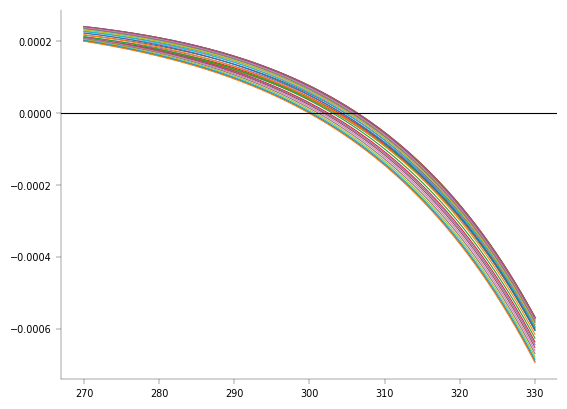

In [151]:
temp_tendency_t_surf_vals = np.linspace(270, 330, 800)
temp_surf_eqb = np.zeros(ds['day'].lat.size)
for i in range(0, ds['day'].lat.size):
    var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['day']['swdn_sfc'].isel(lat=i).max()),
                            float(opd_lw_gray(ds['day'].lat.isel(lat=i))))
    temp_surf_eqb[i] = temp_tendency_t_surf_vals[np.argmin(np.abs(var))]
    plt.plot(temp_tendency_t_surf_vals, var)
# lat_use = 90
# a = get_temp_tendency(np.linspace(270, 330, 50), float(ds['day']['swdn_sfc'].sel(lat=lat_use, method='nearest').max()),
#                       float(opd_lw_gray(ds['day'].lat.sel(lat=lat_use, method='nearest'))))
# plt.plot(np.linspace(270, 330, 50), a)
# lat_use = 0
# a = get_temp_tendency(np.linspace(270, 330, 50), float(ds['day']['swdn_sfc'].sel(lat=lat_use, method='nearest').max()),
#                       float(opd_lw_gray(ds['day'].lat.sel(lat=lat_use, method='nearest'))))
# plt.plot(np.linspace(270, 330, 50), a)
# lat_use = 60
# a = get_temp_tendency(np.linspace(270, 330, 50), float(ds['day']['swdn_sfc'].sel(lat=lat_use, method='nearest').max()),
#                       float(opd_lw_gray(ds['day'].lat.sel(lat=lat_use, method='nearest'))))
# plt.plot(np.linspace(270, 330, 50), a)
plt.axhline(0, color='k')

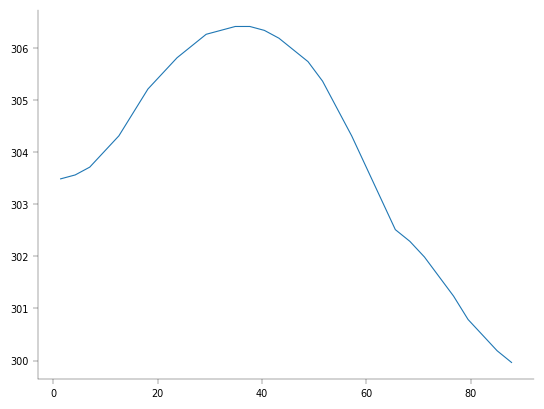

In [152]:
plt.plot(ds['day'].lat, temp_surf_eqb)

In [154]:
a = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/benchmarking/experiments/socrates/ozone_1990.nc', decode_times=False)

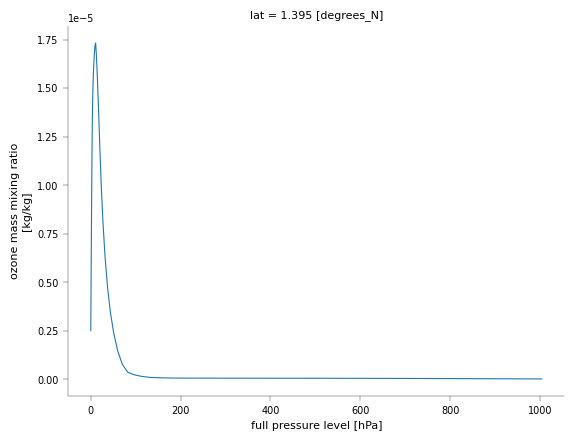

In [172]:
a.isel(time=5, lon=0, drop=True).ozone_1990.sel(lat=0, method='nearest').plot()

In [183]:
ds_use = isca_tools.load_dataset(exp_dir + exp_name[0], decode_times=True)